In [6]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2023. Mohamed Reda Bouadjenek, Deakin University              +
#           Email:  reda.bouadjenek@deakin.edu.au                              +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Introduction

Welcome to your assignment this week!


To deepen our comprehension of safety in AI, this assignment delves into a practical scenario involving **Image Classification** for traffic signs.





<img src="images/0_SkE_FOCh8qGP9Zqh.png" width="450"/>

In the realm of artificial intelligence, ensuring safety stands as a paramount concern, particularly when the technology is harnessed for critical applications like autonomous driving vehicles. One example is the recognition of traffic signs, where the consequences of inaccurate predictions can reverberate dramatically, potentially resulting in tragic loss of life. In light of these profound implications, this assignment delves into the imperative topic of safety in AI, centering on the vital context of image classification for traffic signals.





Through an examination of safety within the realm of traffic sign classification, our objective is to unveil and mitigate potential risks inherent in such systems. This endeavor is driven by the pursuit of a more profound comprehension of how AI algorithms can inadvertently introduce risks and uncertainties.



Run the following cell to load the packages you will need for this assignment.


In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
from tqdm import trange

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)


GPU is used.
Tensorflow version: 2.19.0


# Preprocessing


We use a traffic sign dataset that is composed of 48 folders (one for each sign) with 20-500 images in each folder. The total number of images is about 10,000.

For reading these images, we use `DirectoryIterator` in `tf.keras.preprocessing.image` that is an iterator capable of reading images from a directory on disk and is capable to extract labels. We also use `ImageDataGenerator` to split this dataset into training and validation set, this later is used to tune the hyperparameters of our model.


In [8]:
'''
    Split train and validation.
'''
# We define the size of input images to 64x64 pixels.
image_size = (64, 64)
# We define the batch size
batch_size = 64

# Create an image generator with a fraction of 40% images reserved for validation:
image_generator = ImageDataGenerator(validation_split=0.4)

# Now, we create a training data iterator by creating batchs of images of the same size as
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "traffic_sign_dataset/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "traffic_sign_dataset/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes


Found 5815 images belonging to 48 classes.
Found 3846 images belonging to 48 classes.


# Exploring the data

Now, we do data exploration to show you samples of the images and their labels and some statistics to help you in understanding the data.

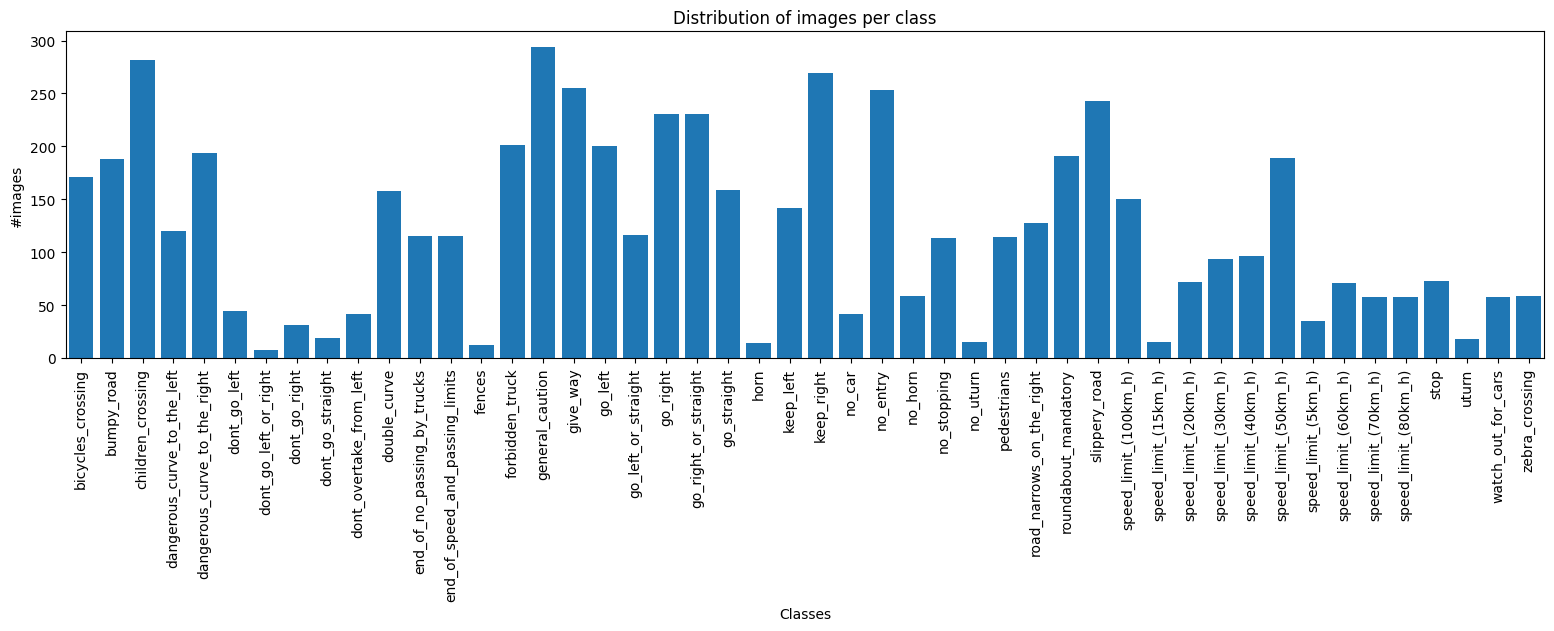

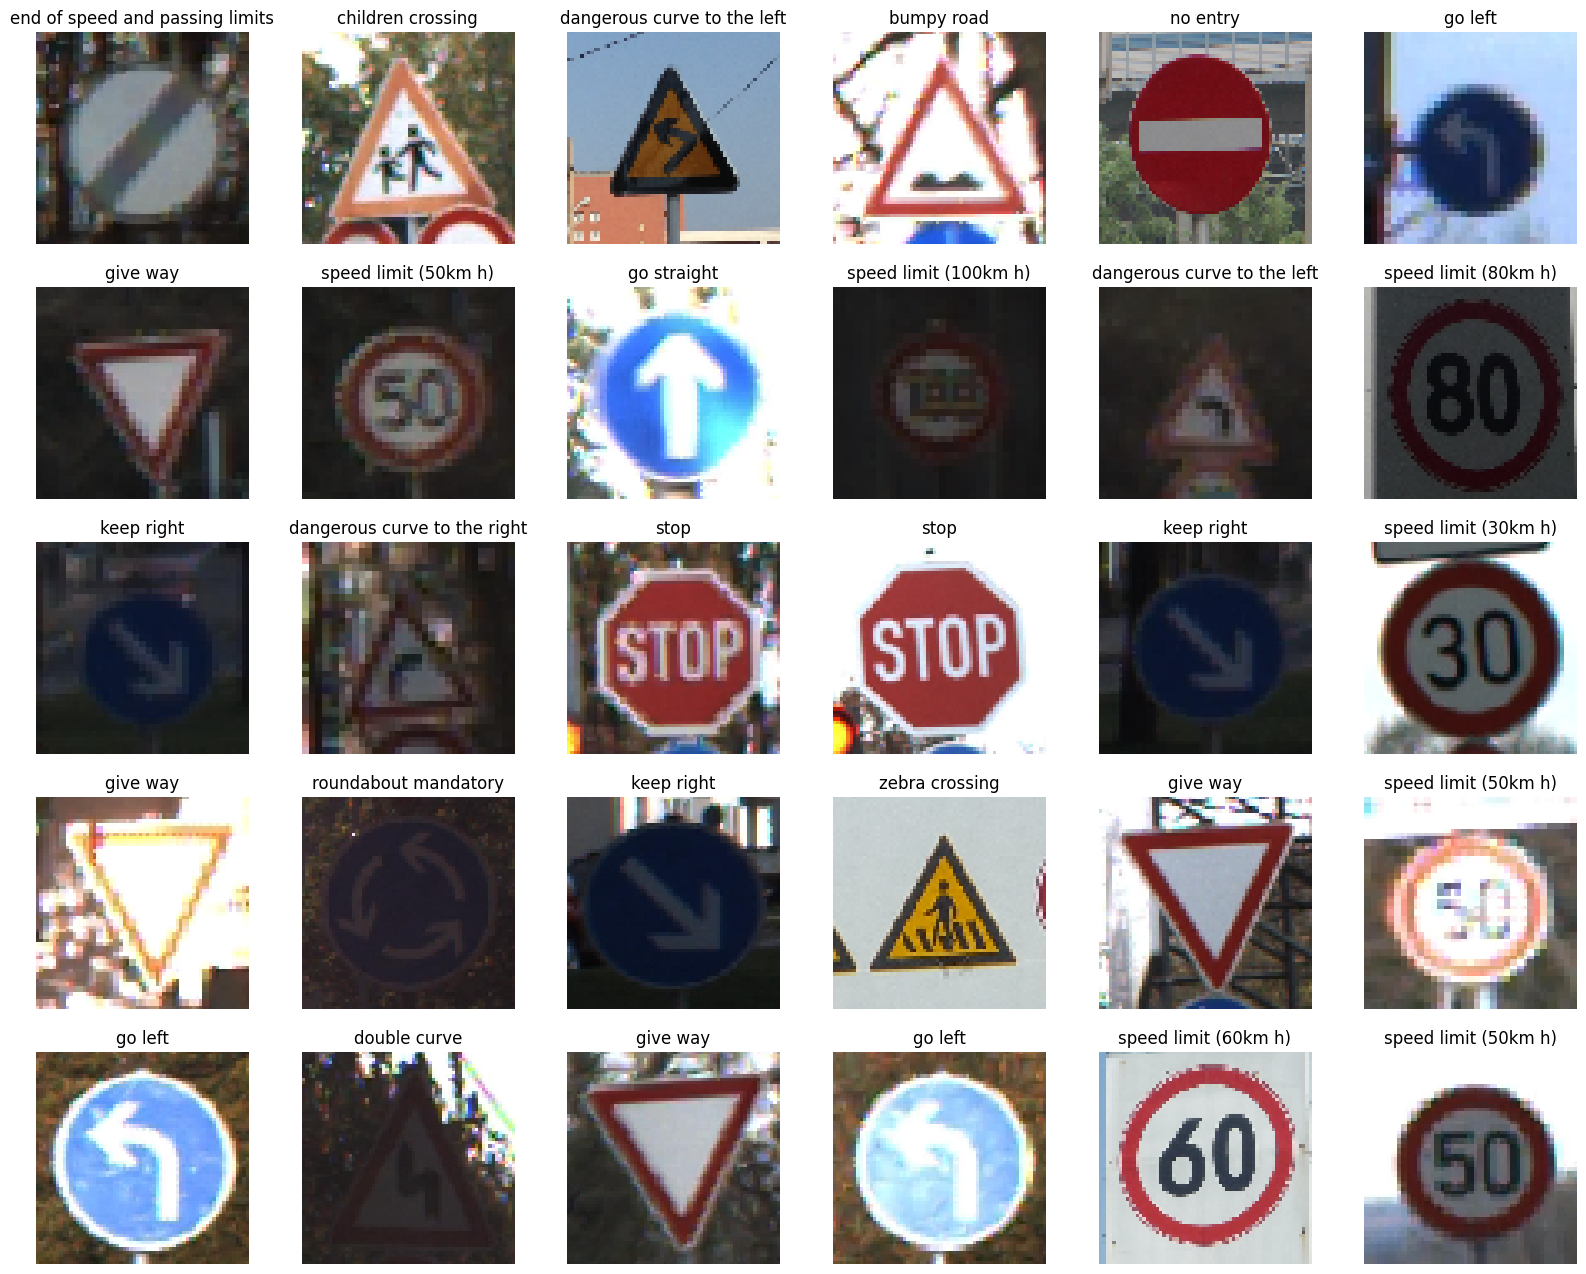

In [9]:
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter(train_ds.labels)
v = [ [class_names[item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar',
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class")
plt.xticks(rotation='vertical')
plt.show()

#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(20, 16))
images = []
labels = []
for itr in train_ds.next():
    for i in range(30):
        if len(images) < 30:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' '))
    plt.axis("off")

plt.show()


# Designing the model


We now design the architecture for the task.

In [10]:
# Defining your model here:
model = models.Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))

## <span style="color:red"><b>TASK 1</b></span>


Define a convolutional neural network (CNN) architecture as follows:

1. CNN Block 1:
    - Add a dropout layer with a dropout rate of 0.25. Dropout is a regularization technique that randomly sets a fraction of input units to 0 during training, which helps prevent overfitting.
    - Add a convolutional layer with 16 filters, each having a 5x5 receptive field. The activation function used is ReLU (Rectified Linear Unit), and "same" padding ensures that the output size remains the same as the input size.
    - Add a max-pooling layer with a 2x2 pool size. Max-pooling reduces the spatial dimensions of the previous layer's output, helping to retain important features while reducing computational complexity.

2. CNN Block 2:
    - Add another dropout layer with a dropout rate of 0.25.
    - Similar to the first convolutional layer, add another convolutional layer with 32 filters, each having a 5x5 receptive field and ReLU activation.
    - Add another max-pooling layer  after the second convolutional layer with a 2x2 pool size.

3. CNN Block 3:
    - Add another dropout layer with a dropout rate of 0.25.

    - Add a third convolutional layer with 32 filters, each having a 5x5 receptive field and ReLU activation.

    - Add another max-pooling layer after the third convolutional layer with a 2x2 pool size.

4. CNN Block 4:    
    - Add another dropout layer with a dropout rate of 0.25.
    - Add a fourth convolutional layer with 32 filters, each having a 5x5 receptive field and ReLU activation.
    - Add another max-pooling layer after the third convolutional layer with a 2x2 pool size.



In [11]:
## START YOU CODE HERE
# CNN Block 1
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(16, (5,5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))

# CNN Block 2
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (5,5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))

# CNN Block 3
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (5,5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))

# CNN Block 4
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (5,5), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))

## END

In [12]:
model.add(layers.Flatten())
#Dense part
model.add(keras.layers.Dropout(0.25))
model.add(layers.Dense(num_classes, activation='softmax'))
# Print a summary of the model
model.summary()

# Compiling the model by defininf an optimizer, a loss function,
# and the metrics to be used for monitoring the traning.
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │        24,624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,936 (351.31 KB)

 Trainable params: 89,936 (351.31 KB)

 Non-trainable params: 0 (0.00 B)

# Traning

Let's now starting the training process.

In [13]:
# Start the trining by defining the number of epochs to train, the traing set and the validation set.
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4335s 48s/step - accuracy: 0.0511 - loss: 3.7197 - val_accuracy: 0.1594 - val_loss: 3.4368
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 378ms/step - accuracy: 0.1755 - loss: 3.0830 - val_accuracy: 0.3053 - val_loss: 2.6780
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.3831 - loss: 2.2566 - val_accuracy: 0.3645 - val_loss: 2.3283
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.4961 - loss: 1.7485 - val_accuracy: 0.4093 - val_loss: 2.0798
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 384ms/step - accuracy: 0.5743 - loss: 1.4443 - val_accuracy: 0.4074 - val_loss: 2.1246
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.6288 - loss: 1.2175 - val_accuracy: 0.4696 - val_loss: 1.8713
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.6892 - loss: 1.0024 - val_accuracy: 0.4659 - val_loss: 1.9521
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.7523 - loss: 0.8263 - val_accu

# Monitoring and analysis of the model

The next step consists of monitoring the traning process to investigate possible overfitting.


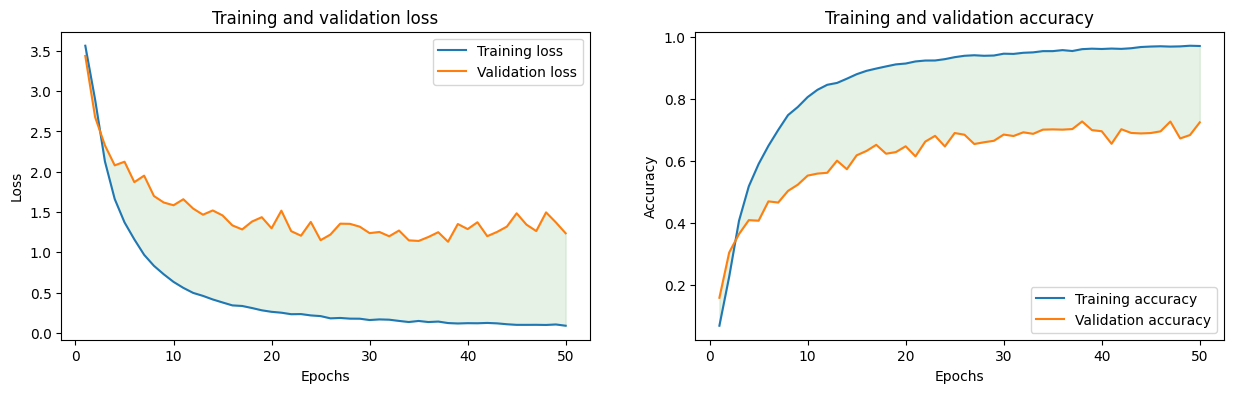

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Run the `classification_report` function below to build a text report showing the main classification metrics for your model:

In [15]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
print(classification_report(y_true, y_pred, target_names=class_names))

61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step
                                 precision    recall  f1-score   support

              bicycles_crossing       0.78      0.50      0.61       113
                     bumpy_road       0.98      0.79      0.88       124
              children_crossing       0.49      0.97      0.66       187
    dangerous_curve_to_the_left       0.68      0.43      0.53        79
   dangerous_curve_to_the_right       0.88      0.67      0.76       129
                   dont_go_left       1.00      0.83      0.91        29
          dont_go_left_or_right       1.00      1.00      1.00         4
                  dont_go_right       0.82      0.45      0.58        20
               dont_go_straight       1.00      1.00      1.00        12
        dont_overtake_from_left       1.00      0.67      0.80        27
                   double_curve       0.73      0.63      0.67       105
    end_of_no_passing_by_trucks       0.77      0.91      0.83        76
end_of_s

Run the  next cell to create a confusion matrix function `plot_confusion_matrix`.

In [16]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100

    plt.figure(figsize=(14,14))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)


Let's now create the confusion matrix.

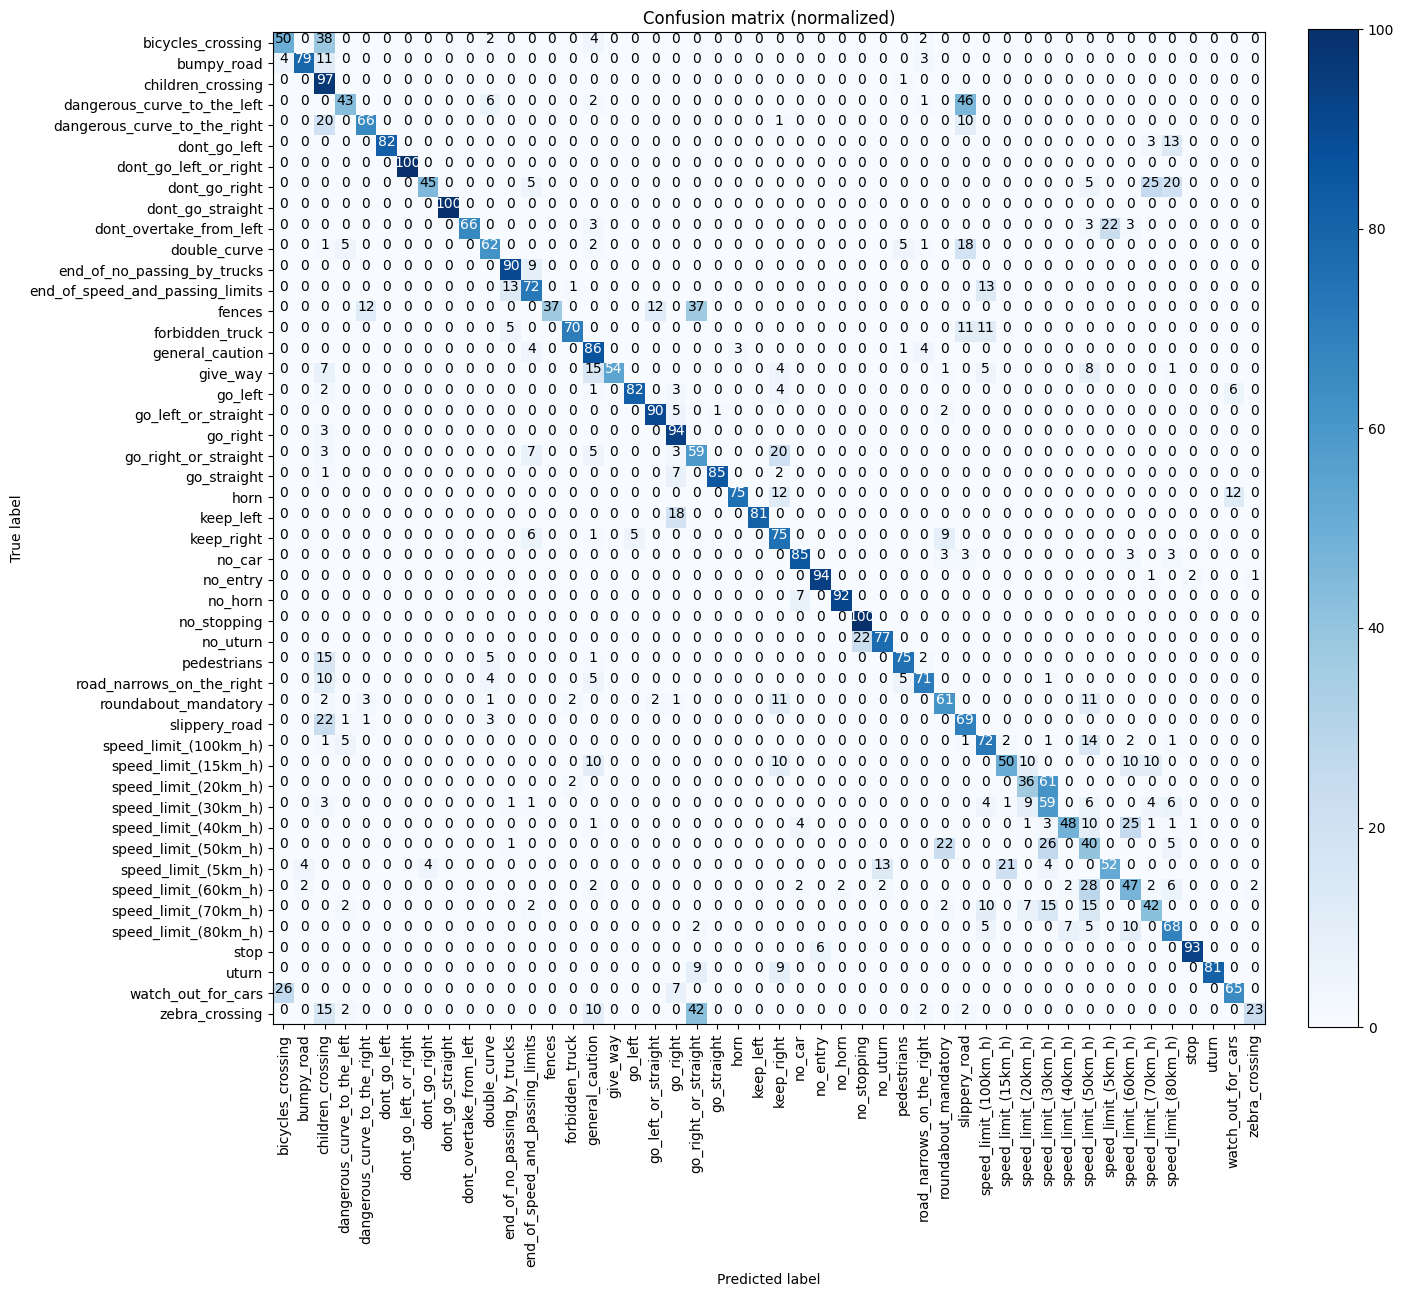

In [17]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)


## <span style="color:red"><b>TASK 2</b></span>


Examine the confusion matrix and provide an observation-based description of its content and patterns.


***

1. Strong Diagonal Pattern
    - The confusion matrix shows a dominant diagonal line, meaning that most traffic sign images are correctly classified into their true categories.
    - This indicates that the model performs well overall, with high accuracy for many classes.

2. Well-Classified Classes
    - Signs like “stop,” “pedestrians,” “zebra_crossing,” “speed_limit(20km_h),” and “no_entry” have very strong diagonal entries with minimal off-diagonal confusion.
    - This suggests the model can reliably recognize visually distinctive signs.

3. Confusion Between Similar Speed Limit Signs
    - There is noticeable misclassification among speed limit signs, e.g
      - speed_limit(30km_h) sometimes confused with speed_limit(20km_h) or speed_limit(50km_h).
      - speed_limit(80km_h) confused with speed_limit(60km_h).
    - This is expected because these signs are visually similar, differing mainly in the number inside the circle.

4. Directional Signs Confusion
    - Signs such as “go_left_or_straight,” “go_right_or_straight,” “go_straight,” and “keep_right” show misclassification across each other.
    - These signs share similar shapes and arrows, which can confuse the model.

5. Rare Classes Have More Errors
    - Less frequent classes (e.g., “children_crossing,” “slippery_road,” “bicycles_crossing”) have weaker diagonal dominance and higher confusion with unrelated classes.
    - This suggests that class imbalance in the dataset may contribute to poorer performance for these categories.

6. General Trends
    - Visually distinctive signs (like stop or no entry) → highly accurate.
    - Visually similar categories (speed limits, directional arrows) → most confusion.
    - Underrepresented classes → lower performance due to fewer training examples.


***


Let's now have a look at miss-classified examples by your model:

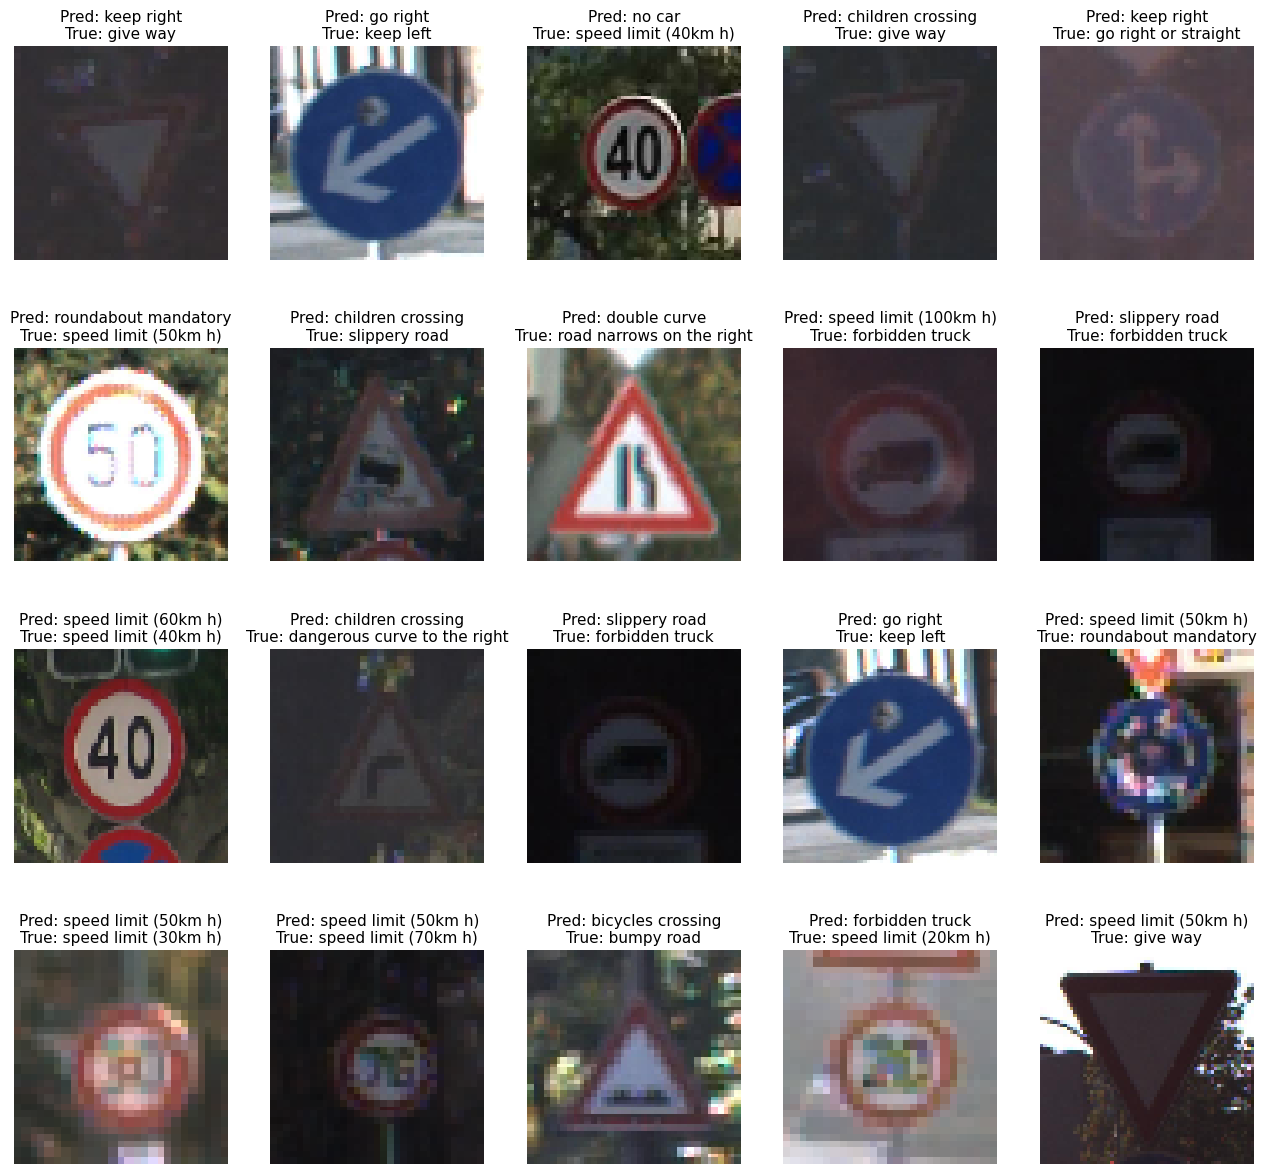

In [18]:
val_ds.reset()
val_ds.shuffle = True
#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 15))
images = []
labels_pred = []
labels_true = []
while len(images) < 20:
    batch , labels = val_ds.next()
    for i in range(batch.shape[0]):
        y_prob_ = model.predict(np.array([batch[i]]), verbose=0)
        y_pred_ = np.argmax(y_prob_, axis=1)[0]
        y_true_ = list(labels[i]).index(1)
        if y_true_!=y_pred_:
            images.append(batch[i].astype("uint8"))
            labels_pred.append(y_pred_)
            labels_true.append(y_true_)

for i in range(20):
    if labels_pred[i] != labels_true[i]:
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ')


        plt.title(title,fontsize= 11, pad=5)
        plt.axis("off")


## <span style="color:red"><b>TASK 3</b></span>

Take a moment to relect on the mistakes your model may generate and consider the potential risks these errors pose in a critical application such as an autonomous driving vehicle.

***

- **Safety-critical mis-decisions:** confusing pedestrians or zebra_crossing with a less severe sign can directly lead to failure to brake, causing collisions. Misreading stop or no_entry would be catastrophic in intersections.

- **Incorrect speed control:** confusing speed-limit numerals (e.g., 50 ↔ 80) can lead to unsafe speeding or overly cautious driving that disrupts traffic flow and increases accident risk.

- **Wrong maneuvers:** directional misclassifications (roundabout vs. keep-right) may cause inappropriate steering/braking, leading to unsafe lane changes or missed maneuvers.

- **Loss of trust and cascading failures:** frequent false positives/negatives undermine system reliability; downstream planning modules may behave erratically.

- **Vulnerability to environmental conditions:** errors concentrated in low-light/occluded images show the system would be unreliable at night or in adverse weather.


***

# Monte carlo Dropout

Monte Carlo Dropout is a technique used in deep learning to estimate uncertainty in predictions made by a neural network. Regular dropout is a technique where during training, random neurons are "dropped out" by setting their outputs to zero. This prevents the network from becoming overly reliant on specific neurons and helps with generalization.

In the context of Monte Carlo Dropout, dropout is applied not only during training but also during inference (when making predictions). Instead of using a single forward pass to make a prediction, Monte Carlo Dropout involves performing multiple forward passes with dropout enabled. By averaging the predictions from these multiple passes, you can obtain a more robust estimate of uncertainty associated with each prediction.

Monte Carlo Dropout provides a way to model and quantify uncertainty in neural network predictions. It's particularly useful in tasks like Bayesian deep learning and uncertainty estimation for tasks such as image classification, where knowing the uncertainty of each prediction can be beneficial.


In [23]:
val_ds.reset()
val_ds.shuffle = False
# Initialize an empty list to store batches of data
X_val = []

# Iterate through all batches of data
for batch in val_ds:
    # Append the current batch to the list
    X_val.append(batch[0])  # Assuming batch[0] contains the data
    # Break the loop when all batches have been processed
    if val_ds.batch_index == 0:
        break

X_val = np.concatenate(X_val, axis=0)


## <span style="color:red"><b>TASK 4</b></span>

Iterate through the specified number of predictions (200) and utilize dropout when making predictions with the trained model.






In [32]:
# Initialize an empty list to store predictions
mote_carlo_pred = []
# Loop through the desired number of predictions
for _ in trange(200, ncols=100):
    ## START YOU CODE HERE
    # Forward pass with dropout enabled during inference
    y_prob_iter = model(X_val, training=True).numpy()
    y_pred_iter = y_prob_iter.argmax(axis=-1)

    # On first iteration, set up per-sample buckets
    if not mote_carlo_pred:
        mote_carlo_pred.extend([[] for _ in range(len(y_pred_iter))])

    # Append this iteration’s prediction for each sample
    for i, pred in enumerate(y_pred_iter):
      mote_carlo_pred[i].append(int(pred))

    ## END

100%|█████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.50it/s]


## <span style="color:red"><b>TASK 5</b></span>

In our approach, we leverage the concept of entropy as a fundamental tool to estimate uncertainty. By measuring the level of unpredictability within a given set of predictions, entropy provides a quantifiable metric that helps us gauge the uncertainty associated with each prediction. This utilization of entropy enables us to make more informed decisions and predictions in scenarios where uncertainty plays a pivotal role, fostering a deeper understanding of the underlying data dynamics and enhancing the reliability of our outcomes.


In [33]:
def get_entropy(vector):
    """
    Calculate the entropy of a given vector.

    Parameters:
        vector (list or numpy array): Input data vector.

    Returns:
        float: The computed entropy value.
    """
    ## START YOU CODE HERE
    v = np.asarray(vector).ravel()
    # counts over all classes so vector length matches num_classes
    counts = np.bincount(v, minlength=num_classes).astype(np.float64)
    total = counts.sum()
    if total == 0:
        return 0.0
    p = counts / total
    # avoid log(0)
    p = p[p > 0]
    entropy = float(-np.sum(p * np.log(p)))
    ## END
    return entropy


## <span style="color:red"><b>TASK 6</b></span>

Find the most frequent prediction for each set of predictions in mote_carlo_pred and calculate the entropy of each set of predictions, storing both the most frequent predictions and the calculated entropies in separate lists (y_pred_most_freq and entropy, respectively).


In [34]:
y_pred_most_freq = []
entropy = []
for data in mote_carlo_pred:
    ## START YOU CODE HERE
    counts = np.bincount(np.asarray(data), minlength=num_classes)
    y_pred_most_freq.append(int(np.argmax(counts)))
    entropy.append(get_entropy(data))
    ## END

Let's proceed to contrast the accuracy achieved by our model with that obtained through the utilization of the most frequently predicted value employing Monte Carlo dropout.




In [36]:
print('Accuracy of our model:', accuracy_score(y_pred, y_true))
print('Accuracy utilizing the most frequently predicted value employing Monte Carlo dropout:',
      accuracy_score(y_pred_most_freq, y_true))


Accuracy of our model: 0.7238689547581904
Accuracy utilizing the most frequently predicted value employing Monte Carlo dropout: 0.765730629225169


## <span style="color:red"><b>TASK 7</b></span>


What do you conclude from the obtained performance?
***

The Monte Carlo dropout approach improved validation accuracy from 72.39% to 76.57% (a gain of +4.19 percentage points, ~5.8% relative). This tells us two things. First, our single forward pass is a bit noisy/miscalibrated, and averaging many stochastic passes (dropout on) acts like a cheap ensemble that stabilises decisions. Second, the gain likely comes from better handling of borderline cases (e.g., visually similar signs), where consensus over many passes reduces random errors.

Practically, this means uncertainty-aware inference helps both accuracy and safety. When entropy is high, the model is unsure; in a real system we can slow down, defer to other sensors/maps, or hand over control. When entropy is low, decisions are more trustworthy.


***

Let's now organize information about predictions, whether they are correct or incorrect, their associated entropy values, and their confidence scores into a Pandas DataFrame for further analysis and visualization.

In [37]:
confidence_scores = np.max(y_prob, axis=1)
data = {'Prediction': np.array(['Correct' if x == y else 'Incorrect' for x, y in zip(y_pred, y_true)]),
        'Entropy value': entropy,
        'Confidence score': confidence_scores}

df = pd.DataFrame(data)


Let's employ boxplots of the entropy and confidence score distributions to illustrate the distinction between accurate and erroneous predictions.


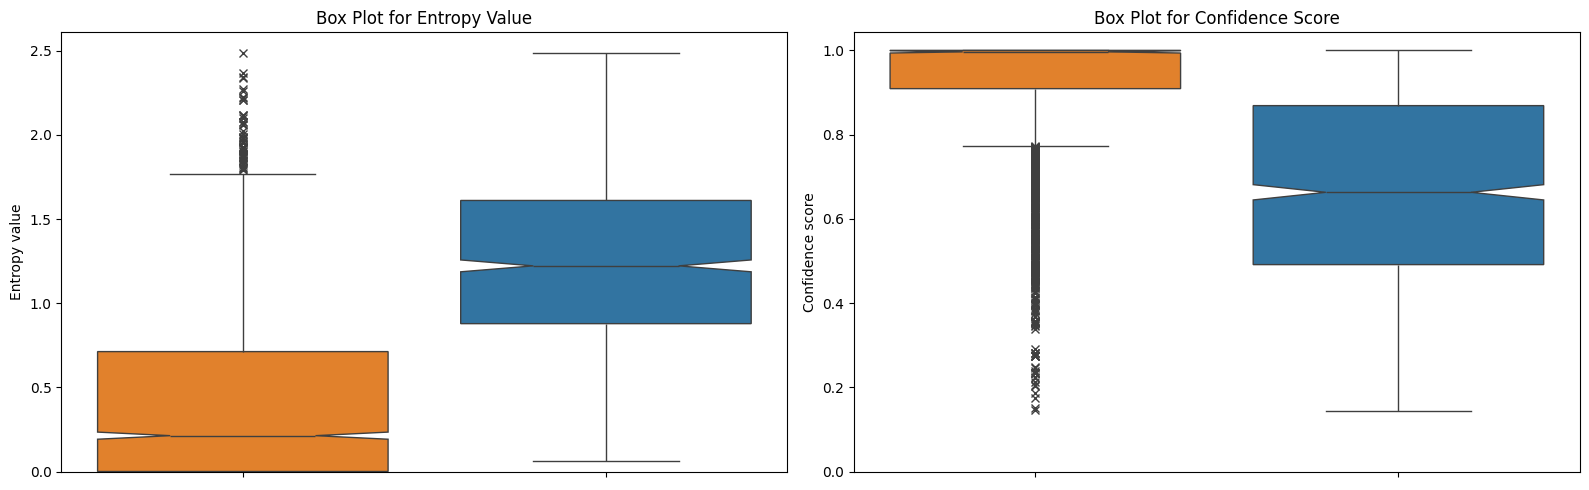

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot for 'Entropy value'
sns.boxplot(data=df,
            x='Prediction',
            y='Entropy value',
            hue='Prediction',
            order=["Correct", "Incorrect"],
            notch=True,
            showcaps=True,
            flierprops={"marker": "x"},
            ax=axes[0])  # Put it in the first subplot (axes[0])

axes[0].set_xticklabels([])
axes[0].set(xlabel='')
axes[0].set(ylim=(0, None))
axes[0].set_title('Box Plot for Entropy Value')

# Box plot for 'Confidence score'
sns.boxplot(data=df,
            x='Prediction',
            y='Confidence score',
            hue='Prediction',
            order=["Correct", "Incorrect"],
            notch=True,
            showcaps=True,
            flierprops={"marker": "x"},
            ax=axes[1])  # Put it in the second subplot (axes[1])

axes[1].set_xticklabels([])
axes[1].set(xlabel='')
axes[1].set(ylim=(0, None))
axes[1].set_title('Box Plot for Confidence Score')

# Adjust the layout
plt.tight_layout()

# Show the subplots
plt.show()


## <span style="color:red"><b>TASK 8</b></span>

What do you conclude from the obtained results?
***

The boxplots show a clear pattern: correct predictions have low entropy (tight spread near zero) and high confidence (close to 1.0), while incorrect predictions have higher entropy and lower confidence on average. This means our uncertainty signal is meaningful—when entropy is high, the model is unsure and more likely to be wrong. However, there are important outliers: some wrong predictions still appear with very high confidence (over-confident errors), and a few correct ones show high entropy (borderline cases).


***


Let's proceed to visualize the achieved accuracy against the proportion of predicted examples from the validation set, considering different entropy cutoff values.



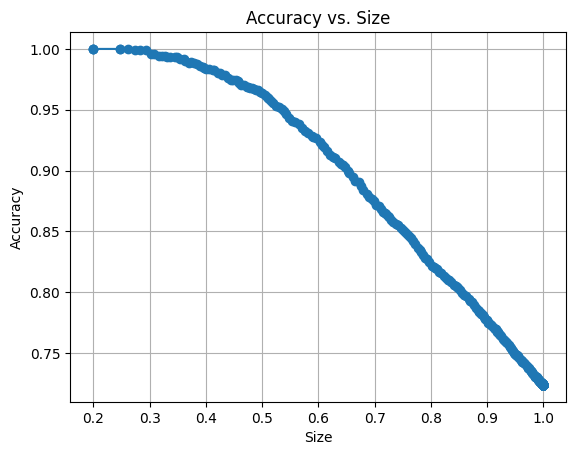

In [39]:
accuracy = []
size = []
for v in [x * 0.01 for x in range(1, 410)]:
    df2 = df[(df['Entropy value']<v)]
    count = len(df2[df2['Prediction'] == 'Correct'])
    accuracy.append(count/len(df2))
    size.append(len(df2)/len(df))
# Create a line plot
plt.plot(size, accuracy, marker='o', linestyle='-')

# Set labels for x and y axes
plt.ylabel('Accuracy')
plt.xlabel('Size')

# Set a title for the plot
plt.title('Accuracy vs. Size')

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

## <span style="color:red"><b>TASK 9</b></span>

What do you conclude from the obtained results?

***

The curve shows a classic accuracy–coverage trade-off. When we keep only low-entropy (certain) samples, accuracy rises close to 100%, but the fraction of kept samples (size) becomes small. As we include more samples (larger size), accuracy drops smoothly to the baseline (~0.72 at full coverage).

This means entropy is a useful confidence signal: low-entropy predictions are usually correct, and high-entropy ones are risky. In practice, we can set an entropy threshold to meet our safety target. For example, if we want ~90% accuracy, the plot suggests accepting about 70–75% of the data and deferring the rest to a fallback (e.g., second model, human, or map checks). Choose the threshold on a calibration split to avoid optimism.


***


## <span style="color:red"><b>TASK 10</b></span>

Could you propose an alternative technique that harnesses uncertainty to enhance the model's overall performance?


***
Deep Ensembles with selective prediction (and optional temperature scaling).

Idea: Train M separate CNNs (different seeds/initialization/augmentation). At inference, average their softmax probabilities (better calibration than a single model), and use disagreement/entropy across models as the uncertainty signal.

  - Prediction
  $$
  \bar{\mathbf{p}} \;=\; \frac{1}{M}\sum_{m=1}^{M} \mathbf{p}^{(m)},
  \qquad
  \hat{y} \;=\; \arg\max_{c}\, \bar{p}_{c}
  $$
  Where $M$ is the number of models, $\mathbf{p}^{(m)}$ is model $m$’s softmax vector, and $\hat{y}$ is the predicted class.

  - Uncertainty: use predictive entropy of $$\bar{𝑝}$$ or variance across models; high disagreement ⇒ low trust.

  - Selective rule: accept if entropy ≤ τ; otherwise abstain/slow down/escalate.

  - Why it helps: Deep ensembles reduce over-confident errors, are strong out of the box, and their uncertainty is more reliable than a single network.

  - Extras: Apply temperature scaling on a validation set to improve probability calibration; optionally add test-time augmentation and average over flips/crops to further stabilize predictions.

This approach typically gives higher top-1 accuracy than a single model and safer decisions when combined with an abstention threshold—very similar to your entropy-coverage plot, but with stronger uncertainty estimates.

***


# Acknowledgment

Please feel free contact me if you identify errors, bugs, or issue with this assignment.

**Author:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/), Lecturer of Applied Artificial Intelligence,

**Institution:** Deakin University, School of Information Technology, Faculty of Sci Eng & Built Env

**Adress:** Locked Bag 20000, Geelong, VIC 3220

**Phone:** +61 3 522 78380

**Email:** reda.bouadjenek@deakin.edu.au

**www.deakin.edu.au**
